In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Dict, List
import random

class Analyzer:

    def __init__(self, model: nn.Module, base_model: nn.Module, device: str = 'cpu',seed=42, is_random = True, layer_numbers = 12):
        self.model = model.to(device)
        self.base_model = base_model.to(device)
        self.device = device
        self.hooks = []
        self.layer_data: Dict[str, Dict[str,List[torch.Tensor]]] = {}
        rng = random.Random(seed)
        self._find_linear_layers(rng, rnd = is_random, numbers = layer_numbers)

    def _find_linear_layers(self, rng, rnd, numbers):
        self.linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                # find corresponding base layer
                base_module = dict(self.base_model.named_modules()).get(name, None)
                if base_module is None:
                    raise ValueError(f"Layer {name} not found in base_model")
                self.linear_layers.append((name, module, base_module))
        if rnd == True:
            self.linear_layers = rng.sample(self.linear_layers, numbers)
    
    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks.clear()

    def register_hooks(self):
        for name, layer, _ in self.linear_layers:
            self.layer_data[name] = {'X': [], 'H': []}
            def hook(module, inputs, output,layer_name=name):
                    # inputs is a tuple; take inputs[0]
                    X = inputs[0].detach().cpu()
                    H = output.detach().cpu()
                    self.layer_data[layer_name]['X'].append(X)
                    self.layer_data[layer_name]['H'].append(H)
            handle = layer.register_forward_hook(hook)
            self.hooks.append(handle)
    
    def collect_features(self, dataloader: DataLoader, input_key: str = 'input'):
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                # assume batch is dict with tensor 'input'
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                _ = self.model(**inputs)

        for name in self.layer_data:
            self.layer_data[name]['X'] = torch.cat(self.layer_data[name]['X'], dim=0)
            self.layer_data[name]['H'] = torch.cat(self.layer_data[name]['H'], dim=0)
                
    def get_layer_svds(self, truncate: bool = False, flavor = 'dimension', truncate_p: float = 0.2) -> Dict[str, List[torch.Tensor]]:
        svd_dict: Dict[str, List[torch.Tensor]] = {}

        for name, layer, base_layer in self.linear_layers:
            W = layer.weight.detach().cpu()
            W0 = base_layer.weight.detach().cpu()
            tau = W-W0
            U, S, Vh = torch.linalg.svd(tau, full_matrices = False)
            V = Vh.T

            if truncate:
                assert 0 <= truncate_p <= 1, "truncate percentage must be between 0 and 1"
                if flavor == 'dimension':
                    rank = int(truncate_p * S.size(0))
                    if rank<1: 
                        rank = 1
                    U=U[:,:rank]
                    S=S[:rank]
                    V=V[:, :rank]
                elif flavor == 'energy':
                    tot = torch.square(S).sum()
                    if tot != 0:
                        threshold = truncate_p * tot
                        cumsum = torch.cumsum(torch.square(S), dim=0)
                        ranks = (cumsum >= threshold).nonzero(as_tuple=False)
                        rank = ranks[0].item()
                        if len(ranks) == 0:
                            rank = len(S)
                    U=U[:, :rank]
                    S=S[:rank]
                    V=V[:, :rank]
            
            svd_dict[name] = [U,S,V]

        return svd_dict
    def get_layer_inputs(self) -> Dict[str, torch.Tensor]:
        return {name: data['X'] for name, data in self.layer_data.items()}

    def get_layer_hiddens(self) -> Dict[str, torch.Tensor]:
        return {name: data['H'] for name, data in self.layer_data.items()}


In [2]:
import math
import numpy as np

def compute_drift(ft_dict, pt_dict):
    return {name: (ft_dict[name]-pt_dict[name]) for name in ft_dict.keys()}

def avg_proj_error(
    data_dict: Dict[str, torch.Tensor], 
    svd_dict: Dict[str,List[torch.Tensor]],
    part: str = 'V',
    device: str = None,
) -> Dict[str, float]:

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    
    result : Dict[str, float] = {}
    for name, M in data_dict.items():
        M = M.to(device)
        U,S,V = svd_dict[name]
        basis = (V if part == 'V' else U).to(device)
        M_recenter = M - M.mean(0, keepdim=True)
        P = M_recenter @ basis @ basis.T
        R = M_recenter - P
        rel = (R.norm(dim=1)**2 / M_recenter.norm(dim=1)**2).mean().item()
        result[name]=rel
    return result

def U_V_alignment(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, torch.Tensor]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, torch.Tensor] = {}
    for layer_name, (U1, _, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        U2, _, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]

        P_u1 = U1 @ U1.T          # [d_out, d_out]
        P_u2 = U2 @ U2.T          # [d_out, d_out]
        overlap_U = torch.norm(P_u1 @ P_u2, p='fro') / math.sqrt(min(U1.shape[1], U2.shape[1]))

        P_v1 = V1 @ V1.T          # [d_in, d_in]
        P_v2 = V2 @ V2.T          # [d_in, d_in]
        overlap_V = torch.norm(P_v1 @ P_v2, p='fro') / math.sqrt(min(V1.shape[1], V2.shape[1]))

        results[layer_name] = torch.tensor([overlap_U, overlap_V], device=device)

    return results

def cos_similarity(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, float]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, float] = {}
    for layer_name, (U1, S1, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        S1 = S1.to(device)
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
        U2, S2, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]
        S2 = S2.to(device)
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        
        cos = torch.norm(tau1.T @ tau2) / (torch.norm(tau1)*torch.norm(tau2))

        results[layer_name] = cos

    return results
    

In [3]:
import matplotlib.pyplot as plt
import math

def plot_data_alignment(results_dict: Dict[str, Dict[str, float]]):
    # Extract layer names and dataset names
    dataset_names = list(results_dict.keys())
    # Assume all results have the same layer keys
    layer_names = list(next(iter(results_dict.values())).keys())
    
    # Build matrix of errors
    data_matrix = []
    for d in dataset_names:
        row = [results_dict[d][layer] for layer in layer_names]
        data_matrix.append(row)
    data_matrix = torch.tensor(data_matrix, dtype=torch.float32)
    
    # Plot
    plt.figure()
    plt.imshow(data_matrix, aspect='auto')
    plt.colorbar(label='Projection Error')
    plt.xticks(ticks=range(len(layer_names)), labels=layer_names, rotation=45, ha='right')
    plt.yticks(ticks=range(len(dataset_names)), labels=dataset_names)
    plt.xlabel('Layer')
    plt.ylabel('Dataset')
    plt.title('Layerwise Data Alignment Error Heatmap')
    plt.tight_layout()
    plt.show()

def plot_U_V_alignment(alignment_dict: Dict[str, torch.Tensor]):
    # Extract layers and corresponding values
    layers = list(alignment_dict.keys())
        
    U_vals = []
    V_vals = []
    
    for layer in layers:
        vals = alignment_dict[layer]
        layer= layer.replace("vision_model.", "")
        # Ensure tensor on CPU and convert to floats
        U_vals.append(vals[0].cpu().item())
        V_vals.append(vals[1].cpu().item())
    
    # Plot
    plt.figure()
    plt.figure(figsize=(16,8))
    plt.plot(layers, U_vals, marker='o', label='U alignment')
    plt.plot(layers, V_vals, marker='s', label='V alignment')
    plt.xticks(ticks=layers, labels=layers, rotation=45, ha='right')
    plt.xlabel('Layer')
    plt.ylabel('Subspace Overlap')
    plt.title('U vs V Subspace Alignment per Layer')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cos_similarity(alignment_dict,cmap: str = "viridis"):
    # Extract layers and corresponding values
    layers = list(alignment_dict.keys())
        
    data = []
    
    for layer in layers:
        v = alignment_dict[layer]
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
        else:
            v = np.array(v, dtype=float)
        data.append(v)
       
        # Ensure tensor on CPU and convert to floats
        #cos.append(val)
    data = np.vstack(data)#t3orch #return number of non zero columns
    display_layers = [l.replace("vision_model.", "") for l in layers]
    
    # Plot
    plt.figure()
    plt.figure(figsize=(12, max(4, len(layers) * 0.4)))
    im = plt.imshow(data, aspect="auto", cmap=cmap)
    plt.colorbar(im, label="Cosine similarity")
    plt.yticks(np.arange(len(display_layers)), display_layers, fontsize=8)
    plt.xticks(
        np.arange(data.shape[1]),
        np.arange(data.shape[1]),
        rotation=45,
        ha="right",
        fontsize=8
    )
    plt.xlabel("Component index")
    plt.ylabel("Layer")
    plt.title("Subspace overlap heatmap per layer")
    plt.tight_layout()
    plt.show()

In [4]:
'''for different ft models, compute the linear layer weight orthogonality and corresponding U, V alignments.'''

# Sample cell: Compare two models layerwise subspace alignment

import torch
from transformers import CLIPVisionModel
import matplotlib.pyplot as plt

# Assume ModelAnalyzer, U_V_alignment, plot_U_V_alignment are defined in previous cells
# from your_notebook import ModelAnalyzer, U_V_alignment, plot_U_V_alignment

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Download base and two finetuned models from Hugging Face
base_name   = "openai/clip-vit-base-patch32"
model1_name = "tanganke/clip-vit-base-patch32_stl10"  # replace with your first finetuned repo
model2_name = "tanganke/clip-vit-base-patch32_mnist"  # replace with your second finetuned repo

base_model  = CLIPVisionModel.from_pretrained(base_name, output_hidden_states=True).to(device)
model1      = CLIPVisionModel.from_pretrained(model1_name, output_hidden_states=True).to(device)
model2      = CLIPVisionModel.from_pretrained(model2_name, output_hidden_states=True).to(device)

# 2) Compute layerwise τ‐SVD for each task
analyzer1 = Analyzer(model1, base_model, device=device)
svd_dict1 = analyzer1.get_layer_svds(truncate=True, truncate_p=0.1)

analyzer2 = Analyzer(model2, base_model, device=device)
svd_dict2 = analyzer2.get_layer_svds(truncate=True, truncate_p=0.1)

# 3) Compare U and V subspace alignments per layer
alignment = U_V_alignment(svd_dict1, svd_dict2, device=device)




2025-08-02 03:28:08.030630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754105288.273470      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754105288.347785      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

<Figure size 640x480 with 0 Axes>

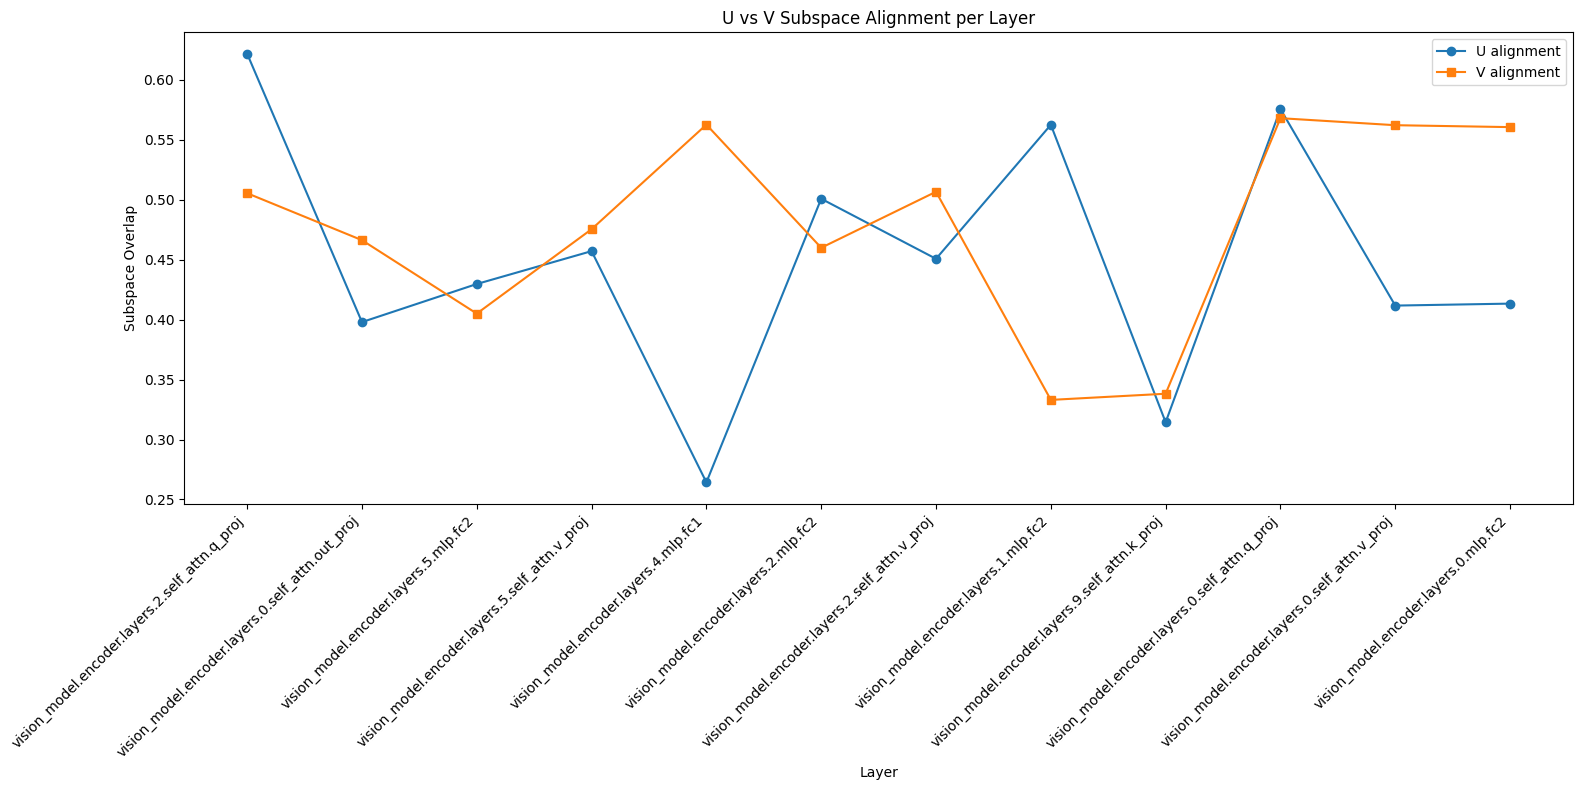

In [5]:
plot_U_V_alignment(alignment)

In [6]:
#similarity = cos_similarity(svd_dict1, svd_dict2, device)

In [7]:
#plot_cos_similarity(similarity)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Dict, List
import random
import scipy
from scipy.linalg import polar

def compute_left_basis(P,beta,W,eps):
    p,k = P.size()

    mask = beta>eps
    idx = mask.nonzero(as_tuple=False).view(-1)
    rank = idx.numel()
    W_r = W[:,-rank:]
    M_r = P@W_r

    beta_r = beta[mask]
    V_r = M_r / beta_r.unsqueeze(0)
    if rank < p:
        Q_full, _ = torch.linalg.qr(V_r, mode = "complete")
        V0 = Q_full[:,rank:]
        V = torch.cat([V0,V_r],dim=1)
    else:
        V = V_r

    return V[:,-p:]

def gsvd(A:torch.tensor,
         B:torch.tensor,
         #truncate: bool = True
)->[torch.tensor]:
    '''
    TODO: fix precision issue for m < n
    '''
    '''
    Does G-SVD on two matrices, A, B, both m x n.

    Input:
        A, B: tensors, matrices

    Output:
        a list of tensors: [U,S_A,V,S_B,W,R,Q], where
            A = U (S_A) (W^T (R)) Q^T
            B = V (S_B) (W^T (R)) Q^T
        U, V, W, Q are unitary matrices
    '''
    
    #Paige and Saunders 1981, section 2
    eps = 1e-12
    m,n = A.size()
    p,_ = B.size()
    
    #joint svd of A, B
    C = torch.vstack([A,B])
    P,R,Qh = torch.linalg.svd(C, full_matrices = True) #2m x 2m, min(2m,n), n x n
    Q = Qh.T

    r_thresh = 0.01 * R.max().item()
    nonzero = R > r_thresh
    k = nonzero.sum().item()

    R = R[:k] 
    
    P1 = P[:m,:k]
    P2 = P[m:,:k]
    
    U, alpha, Wh = torch.linalg.svd(P1, full_matrices = True) #U is m * m, W is k * k, alpha is min(m,k)
    W = Wh.T

    Ia = alpha[alpha >= 1-eps]
    Sa = alpha[(alpha < 1-eps) & (alpha >= eps)]
    Oa = alpha[alpha < 1-eps]

    r = Ia.size(dim=0)
    s = Sa.size(dim=0)
    #alpha_fill = torch.cat((Ia, Sa),0)
    Sigma_A = torch.zeros((m,k), device = A.device, dtype = A.dtype)
    #print(Sigma_A.size(),alpha.size())
    for j in range(min(m,k)):
        Sigma_A[j,j] = alpha[j]

    Ib = torch.ones(k-r-s,device = B.device, dtype = B.dtype)
    Sb = torch.sqrt(torch.clamp(1.0-Sa**2, min=0.0))
    Ob = torch.zeros(max(0,min(p,k)-(k-r)),device = B.device, dtype = B.dtype)

    beta = torch.cat((Ob,Sb,Ib),0)
    beta_fill = torch.flip((beta),dims = (0,)) 
    Sigma_B = torch.zeros((p,k), device = B.device, dtype = B.dtype)
    #print(Sigma_B.size(),beta_fill.size())
    for j in range(min(p,k)):
        Sigma_B[j,j] = beta_fill[j]
    
    Sigma_B = torch.flip(Sigma_B,dims=(0,1))
    
    V = compute_left_basis(P2, beta, W, eps)#[:,:p] #compute the best orthonormal V such that V^T (P2 W) = Sigma_B 
    return [U,Sigma_A,V,Sigma_B,W,torch.diag(R),Q,k]

In [9]:
A = torch.rand(400,500)

B = torch.rand(400,500)

U,S_A,V,S_B,W,R,Q,k = gsvd(A,B)
#U,V,X,C,S = matlab_gsvd(A,B)
#print(np.linalg.norm( A - (U @ C @ X.T.conj() )))
#print(np.linalg.norm( B - (V @ S @ X.T.conj() )))

print(U.shape, S_A.shape, V.shape, S_B.shape, W.shape, R.shape, Q.shape,k)
#print(S_B.diag())
n=Q.shape[0]
WtR = W.T@R
if k < n:
    zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
    WtR= torch.cat([WtR, zeros_pad], dim=1)
M = WtR

print(torch.norm(A-U@S_A@M@Q.T)/torch.norm(A))
print(torch.norm(B-V@S_B@M@Q.T)/torch.norm(B))

torch.Size([400, 400]) torch.Size([400, 447]) torch.Size([400, 400]) torch.Size([400, 447]) torch.Size([447, 447]) torch.Size([447, 447]) torch.Size([500, 500]) 447
tensor(0.0508)
tensor(0.0510)


In [10]:
print(V)

tensor([[ 0.0667,  0.0623, -0.0010,  ..., -0.0219,  0.0069,  0.0013],
        [ 0.0018,  0.0350,  0.0231,  ...,  0.0130,  0.0233, -0.0306],
        [ 0.0024,  0.0203,  0.0438,  ..., -0.0231,  0.0774,  0.0028],
        ...,
        [-0.0757, -0.0305, -0.0541,  ..., -0.0483,  0.0282, -0.0409],
        [ 0.0033,  0.0060, -0.0091,  ..., -0.0411,  0.0343,  0.0450],
        [-0.0195,  0.0580,  0.0221,  ..., -0.0007, -0.0595, -0.0408]])


In [11]:
def gsvd_left_similarity(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, float]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, float] = {}
    for layer_name, (U1, S1, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        S1 = S1.to(device)
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T

        U2, S2, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]
        S2 = S2.to(device)
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        #print(layer_name)
        print(torch.linalg.matrix_rank(tau1), torch.linalg.matrix_rank(tau2))
        U,S_A,V,S_B,W,R,Q,k = gsvd(tau1, tau2)
        #print(k)
        r=100
        
        
        U_r = U[:, :r]          
        V_r = V[:, -r:]          
        #C   = U_k.T @ V_k       
        cos = torch.norm(U_r.T @ V_r) / (torch.norm(U_r)*torch.norm(V_r))
        print(torch.norm(U_r.T@V_r))
        
        results[layer_name] = cos
    return results

In [12]:
similarity = gsvd_left_similarity(svd_dict1, svd_dict2, device=device)
#plot_cos_similarity(similarity)

tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(5.5425, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.7770, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(4.3529, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(4.2040, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(2.4226, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(4.8645, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(4.1572, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(5.3370, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.1236, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(5.1817, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.8972, device='cuda:0')
tensor(76, device='cuda:0') tens

<Figure size 640x480 with 0 Axes>

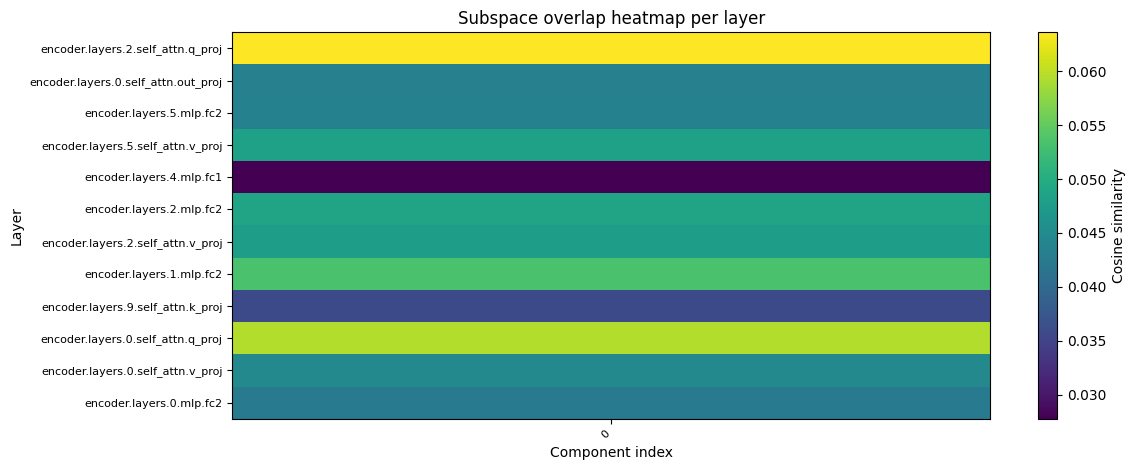

In [13]:
plot_cos_similarity(similarity)

In [14]:
#plot_random_gsvd_S(svd_dict1, svd_dict2)

In [15]:
import torch
import random
import matplotlib.pyplot as plt

def plot_random_gsvd_S(t1_svd_dict, t2_svd_dict, num_layers=4, seed=None):
    """
    Randomly select layers and plot the distributions of S_A and S_B from GSVD
    for each selected layer. Each layer gets its own plot.
    
    Args:
        t1_svd_dict (dict): Mapping layer_name -> (U1, S1, V1) for model 1.
        t2_svd_dict (dict): Mapping layer_name -> (U2, S2, V2) for model 2.
        num_layers (int): Number of layers to randomly select.
        seed (int, optional): Random seed for reproducibility.
    """
    if seed is not None:
        random.seed(seed)
    
    # Ensure deterministic selection if fewer layers than requested
    layer_names = list(set(t1_svd_dict.keys()) & set(t2_svd_dict.keys()))
    selected = random.sample(layer_names, min(num_layers, len(layer_names)))
    
    for layer in selected:
        # Reconstruct tau matrices
        U1, S1, V1 = t1_svd_dict[layer]
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
        U2, S2, V2 = t2_svd_dict[layer]
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        
        # Compute GSVD
        U, S_A, V, S_B, W_R, R_mat, Q, k = gsvd(tau1, tau2)
        
        # Plot distributions
        plt.figure()
        plt.plot(torch.diag(S_A).numpy(), label='S_A')
        #plt.plot(torch.diag(S_B).numpy(), label='S_B')
        plt.plot(torch.diag(R_mat).numpy(), label = 'R')
        plt.title(f"Layer: {layer} GSVD Singular Values")
        plt.xlabel("Component Index")
        plt.ylabel("Singular Value")
        plt.legend()
        plt.show()


In [16]:
from datasets import load_dataset
from transformers import CLIPVisionModel, CLIPProcessor, BertModel, BertTokenizer
from torch.utils.data import DataLoader
import torch

model_names = [
    "tanganke/clip-vit-base-patch32_sun397", 
    "tanganke/clip-vit-base-patch32_mnist"
]
base_model_name = "openai/clip-vit-base-patch32"
dataset_infos = [
    {"hf_name": "ylecun/mnist",       "split": "train[:1%]"},
    {"hf_name": "tanganke/sun397",    "split": "train[:1%]"}
]


device = "cuda" if torch.cuda.is_available() else "cpu"
X_dicts = {}
H_dicts = {}
SVD_dicts = {}

processor = CLIPProcessor.from_pretrained(base_model_name)

for model_name in model_names:
    # Load models
    model = CLIPVisionModel.from_pretrained(model_name, output_hidden_states=True).to(device)
    base_model = CLIPVisionModel.from_pretrained(base_model_name, output_hidden_states=True).to(device)
    analyzer = Analyzer(model, base_model, device=device)
    for ds_info in dataset_infos:
        ds_name = ds_info["hf_name"]
        split = ds_info["split"]
        
        # Load and preprocess dataset
        ds = load_dataset(ds_name, split=split)
        # Detect image column
        from datasets.features import Image as HfImageFeature
        img_col = next(k for k, f in ds.features.items() if isinstance(f, HfImageFeature))
        #print("Using image column:", img_col)
        
        def preprocess(batch):
            enc = processor(images=batch[img_col], return_tensors="pt", padding=True)
            return {"pixel_values": enc["pixel_values"]}
        
        ds_proc = ds.map(preprocess, batched=True, remove_columns=ds.column_names)
        ds_proc.set_format(type="torch", columns=["pixel_values"])
        loader = DataLoader(ds_proc, batch_size=16, shuffle=False)
        
        # Analyze
        analyzer.register_hooks()
        analyzer.collect_features(loader)
        analyzer.remove_hooks()
        
        # Extract dictionaries
        X_dict = analyzer.get_layer_inputs()
        H_dict = analyzer.get_layer_hiddens()
        
        # Store
        X_dicts[(model_name, ds_name)] = X_dict
        H_dicts[(model_name, ds_name)] = H_dict
    
    svd_dict = analyzer.get_layer_svds(truncate=False, flavor = 'energy',truncate_p = 0.9)
    SVD_dicts[model_name] = svd_dict

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

data/train-00000-of-00018.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/train-00001-of-00018.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00018.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

data/train-00003-of-00018.parquet:   0%|          | 0.00/433M [00:00<?, ?B/s]

data/train-00004-of-00018.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

data/train-00005-of-00018.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00006-of-00018.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

data/train-00007-of-00018.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

data/train-00008-of-00018.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

data/train-00009-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00010-of-00018.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

data/train-00011-of-00018.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

data/train-00012-of-00018.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00013-of-00018.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

data/train-00014-of-00018.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

data/train-00015-of-00018.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/train-00016-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00017-of-00018.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/test-00000-of-00018.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

data/test-00001-of-00018.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/test-00002-of-00018.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

data/test-00003-of-00018.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

data/test-00004-of-00018.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

data/test-00005-of-00018.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

data/test-00006-of-00018.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

data/test-00007-of-00018.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/test-00008-of-00018.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/test-00009-of-00018.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

data/test-00010-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/test-00011-of-00018.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/test-00012-of-00018.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

data/test-00013-of-00018.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/test-00014-of-00018.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

data/test-00015-of-00018.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

data/test-00016-of-00018.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

data/test-00017-of-00018.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19850 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19850 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
energies  = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

combos = list(X_dicts.keys())
print(len(combos))

svd_dict_1 = SVD_dicts[model_names[0]]
svd_dict_2 = SVD_dicts[model_names[1]]

for layer_name, (U1, S1, V1) in svd_dict_1.items():
    U1 = U1.to(device)        # [d_out, r1]
    V1 = V1.to(device)        # [d_in,  r1]
    S1 = S1.to(device)
    tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
    U2, S2, V2 = svd_dict_2[layer_name]
    U2 = U2.to(device)        # [d_out, r2]
    V2 = V2.to(device)        # [d_in,  r2]
    S2 = S2.to(device)
    tau2 = U2 @ torch.diag_embed(S2) @ V2.T

    U,Sigma_1,V,Sigma_2,W,R,Q,k = gsvd(tau1,tau2)
    print("====",layer_name,"====")
    print(U.shape,W.shape,R.shape,Q.shape)
    print(torch.diag(R).max().item(),torch.diag(R).min().item())
    print(k)

    n=Q.shape[0]
    WtR = W.T@R
    if k < n:
        zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
        WtR= torch.cat([WtR, zeros_pad], dim=1)
    M = WtR
    print(torch.norm(tau1-U@Sigma_1@M@Q.T)/torch.norm(tau1))
    print(torch.norm(tau2-V@Sigma_2@M@Q.T)/torch.norm(tau2))

    tot = torch.square(torch.diag(R)).sum()
    #threshold = 0.8 * tot
    #cumsum = torch.cumsum(torch.square(torch.diag(R)),dim=0)
    #rank = (cumsum >= threshold).nonzero(as_tuple=False)[0].item()
    #R[rank:,rank:]=0
    
    n=Q.shape[0]
    WtR = W.T@R
    if k < n:
        zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
        WtR= torch.cat([WtR, zeros_pad], dim=1)
    M = WtR@Q.T

    z_energies = []
    y_energies = []
    for combo in combos:
        if combo[0] == model_names[0]:
            Sigma = Sigma_1
        else:
            Sigma = Sigma_2
        X = X_dicts[combo][layer_name]
        X = X.to(M.device)
       
        Xflat = X.reshape(-1,X.size(dim=-1))
        Yflat = Xflat@(M.T)
        e_z = (Yflat.pow(2)).mean(dim=0)
        #e = torch.diag(WtR@WtR.T)
        e_y = (Yflat@(Sigma.T)).pow(2).mean(dim=0)
        z_energies.append(e_z.cpu())
        y_energies.append(e_y.cpu())
        
        sig = (Sigma_1 + Sigma_2).cpu().numpy()
        energies[layer_name] = (z_energies,y_energies,sig)

4
==== vision_model.encoder.layers.2.self_attn.q_proj ====
torch.Size([768, 768]) torch.Size([647, 647]) torch.Size([647, 647]) torch.Size([768, 768])
0.11253032088279724 0.0011296237353235483
647
tensor(0.0238, device='cuda:0')
tensor(0.0306, device='cuda:0')
==== vision_model.encoder.layers.0.self_attn.out_proj ====
torch.Size([768, 768]) torch.Size([761, 761]) torch.Size([761, 761]) torch.Size([768, 768])
0.06992735713720322 0.0007269431371241808
761
tensor(0.0045, device='cuda:0')
tensor(0.0091, device='cuda:0')
==== vision_model.encoder.layers.5.mlp.fc2 ====
torch.Size([768, 768]) torch.Size([1274, 1274]) torch.Size([1274, 1274]) torch.Size([3072, 3072])
0.1306219846010208 0.0013068665284663439
1274
tensor(0.0083, device='cuda:0')
tensor(0.0541, device='cuda:0')
==== vision_model.encoder.layers.5.self_attn.v_proj ====
torch.Size([768, 768]) torch.Size([768, 768]) torch.Size([768, 768]) torch.Size([768, 768])
0.04943547025322914 0.0007281500729732215
768
tensor(0.0004, device='cuda

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce   # for optional downsampling
def plot_matrix_and_vects(M,y1,y2,z1,z2,name1,name2):
    m,n = M.shape
    # — thresholds (means) —
    thr_y = 10*max(y1.mean(), y2.mean())
    thr_z = 10*max(z1.mean(), z2.mean())

    # — optionally downsample M by 4×4 blocks to make each “cell” visible —
    block_h, block_w = 4, 4
    M_ds = block_reduce(M, block_size=(block_h, block_w), func=np.max)
    m2, n2 = M_ds.shape

    # — layout: 2 rows × 2 cols, narrow left col for y‐curves, wide right col for M & z‐curves —
    fig = plt.figure(figsize=(8, 8), dpi=120)
    gs  = fig.add_gridspec(
        nrows=2, ncols=2,
        width_ratios =[1, 4],
        height_ratios=[4, 1],
        wspace=0.15, hspace=0.25
    )

    ax_y = fig.add_subplot(gs[0, 0])
    ax_M = fig.add_subplot(gs[0, 1])
    ax_z = fig.add_subplot(gs[1, 1])

    # — LEFT: y1 & y2 as vertical, filled curves —
    inds_y = np.arange(m)
    h1, = ax_y.plot(  y1,    inds_y, label=name1, lw=1.5)
    h2,= ax_y.plot(  y2,    inds_y, label=name2, lw=1.5)
    ax_y.fill_betweenx(inds_y, y1,   step='mid', alpha=0.2, color = h1.get_color())
    ax_y.fill_betweenx(inds_y, y2,   step='mid', alpha=0.2, color = h2.get_color())
    ax_y.set_xlim(min(y1.min(),y2.min()), thr_y)
    ax_y.invert_yaxis()
    ax_y.set_yticks(np.linspace(0, m, 5))            # pick 5 ticks, or use np.arange(m) if m small
    ax_y.set_yticklabels(np.linspace(1, m, 5, dtype=int))
    ax_y.set_xticks([])
    #ax_y.legend(loc='lower right')

    # — CENTER: heatmap of (downsampled) M plus colorbar —
    im = ax_M.imshow(M_ds, 
                 aspect='auto',
                 interpolation='nearest',
                 cmap='viridis',
                 extent=[0, n, m, 0])   # so y‐axis matches original row indices
    ax_M.set_xticks([])
    ax_M.set_yticks([])
    cbar = fig.colorbar(im, ax=ax_M, fraction=0.046, pad=0.04)
    cbar.set_label('singular values')

    # — BOTTOM: z1 & z2 as horizontal, filled curves —
    inds_z = np.arange(n)
    ax_z.plot(inds_z, z1,   label=name1, lw=1.5, color = h1.get_color())
    ax_z.plot(inds_z, z2,   label=name2, lw=1.5, color = h2.get_color())
    ax_z.fill_between(inds_z, z1,   step='mid', alpha=0.2)
    ax_z.fill_between(inds_z, z2,   step='mid', alpha=0.2)
    ax_z.set_ylim(min(z1.min(), z2.min()), thr_z)
    ax_z.set_xticks(np.linspace(0, n, 6, dtype=int))
    ax_z.set_xticklabels(np.linspace(1, n, 6, dtype=int))
    ax_z.set_yticks([])
    #ax_z.legend(loc='upper right')

    fig.legend(
        handles = [h1,h2],
        labels = [name1,name2],
        loc = 'lower left',
        frameon = False
    )

    plt.show()


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import torch

def plot_energy_layers(
    energies: Dict[str, Tuple[List[torch.Tensor], torch.Tensor, torch.Tensor]],
    combos: List[Tuple[str, str]]
):
    """
    For each layer, plot two figures (one per dataset) showing energy curves.
    Values above 5×the grand‐mean energy for that dataset are hidden by y‐limit.
    
    Args:
        energies: dict mapping layer_name -> list of k‐dim energy tensors,
                  one tensor per (model, dataset) combo in `combos`.
        combos:   list of (model_name, dataset_name) tuples in the same order
                  as energies[layer_name].
    """
    # gather dataset names in order
    dataset_names = sorted({ds for _, ds in combos})
    
    for layer_name, (e_z_list,e_y_list,sig) in energies.items():
        Sigma = sig
        #print(sig1)
        #print(sig2)#.max().item())
        # for each dataset, plot its curves
        for ds in dataset_names:
            # find indices of combos for this dataset
            idxs = [i for i, (_, ds_name) in enumerate(combos) if ds_name == ds]
            if not idxs:
                continue
            #print(idxs)
            # collect flattened arrays
            z_arrs = []
            y_arrs = []
            labels = []
            for i in idxs:
                e_z = e_z_list[i]  
                e_y = e_y_list[i]
                z_arr = e_z.detach().cpu().numpy().flatten()
                z_arrs.append(z_arr)
                y_arr = e_y.detach().cpu().numpy().flatten()
                y_arrs.append(y_arr)
                
                labels.append(combos[i][0])  # model_name for legend
            
            # plot
            print("===",layer_name,"===")
            print("===",ds,"===")
            
            plot_matrix_and_vects(sig,y_arrs[0],y_arrs[1],z_arrs[0],z_arrs[1],model_names[0],model_names[1])

=== vision_model.encoder.layers.2.self_attn.q_proj ===
=== tanganke/sun397 ===


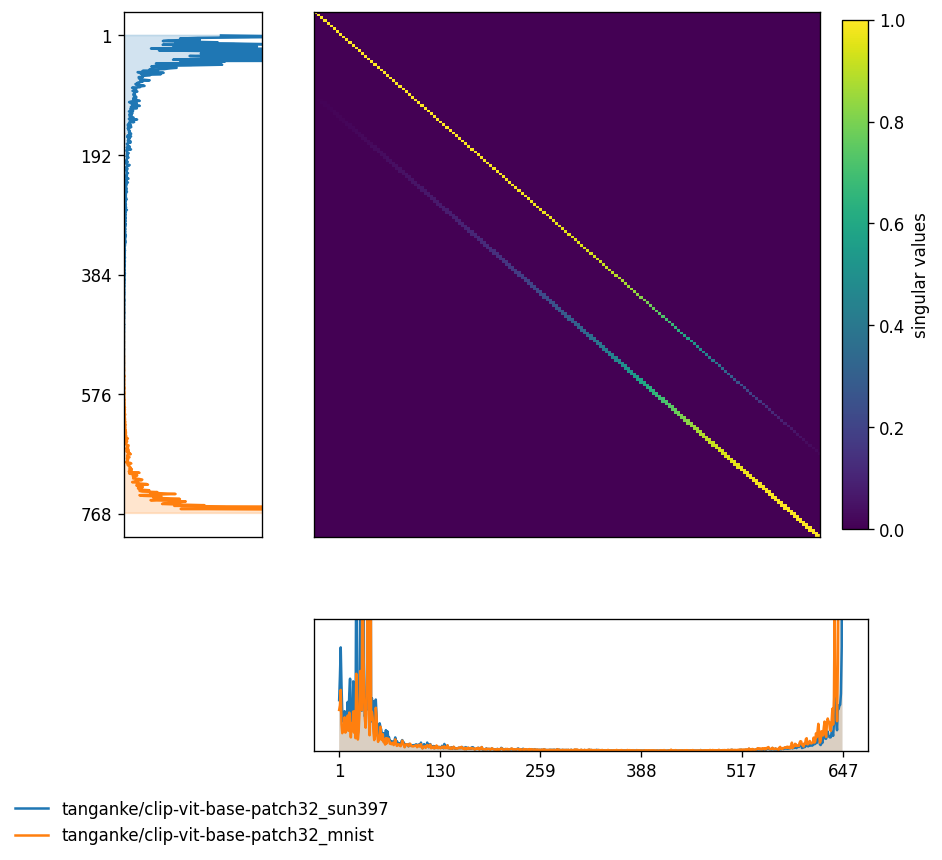

=== vision_model.encoder.layers.2.self_attn.q_proj ===
=== ylecun/mnist ===


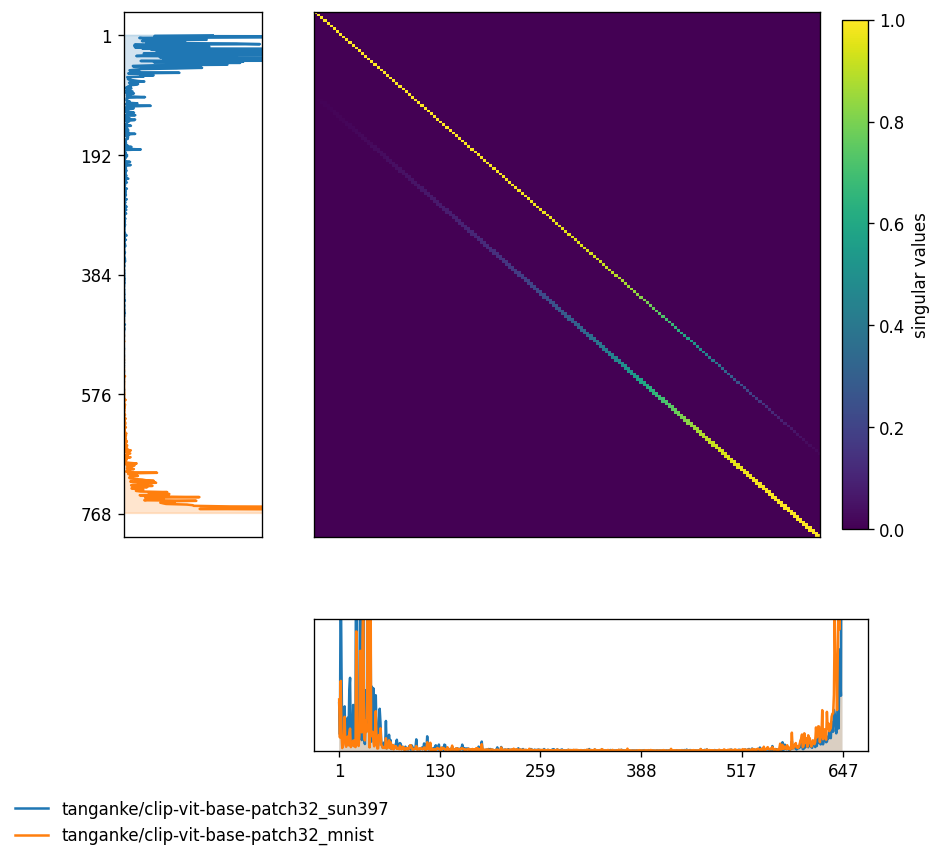

=== vision_model.encoder.layers.0.self_attn.out_proj ===
=== tanganke/sun397 ===


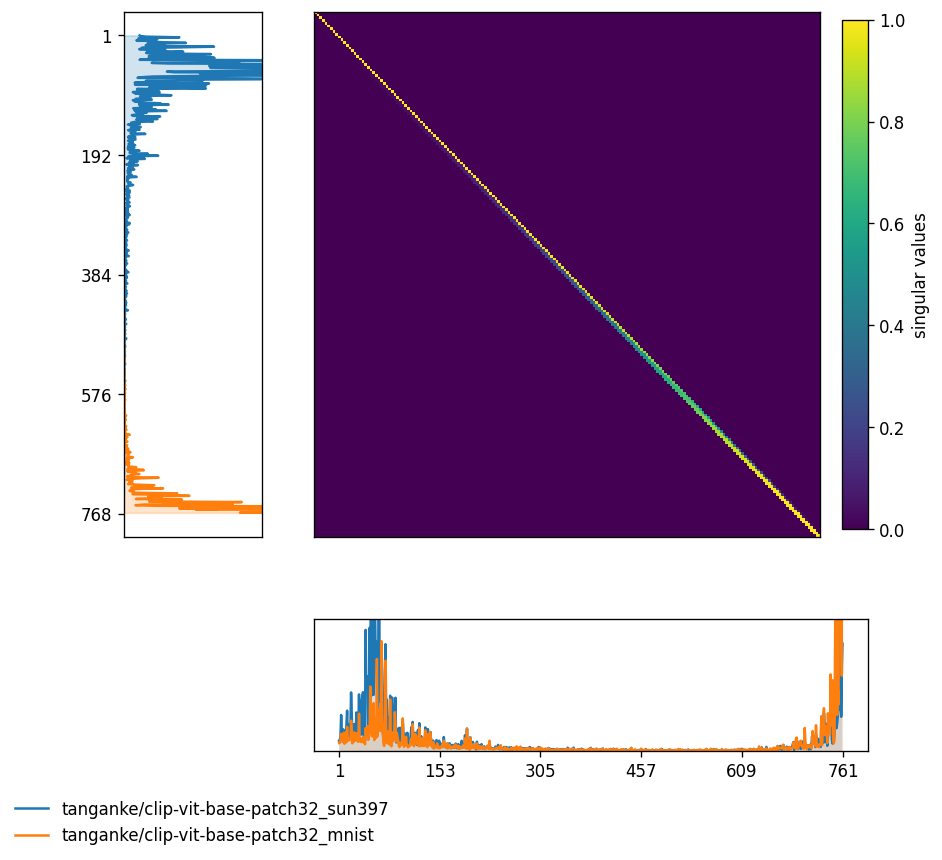

=== vision_model.encoder.layers.0.self_attn.out_proj ===
=== ylecun/mnist ===


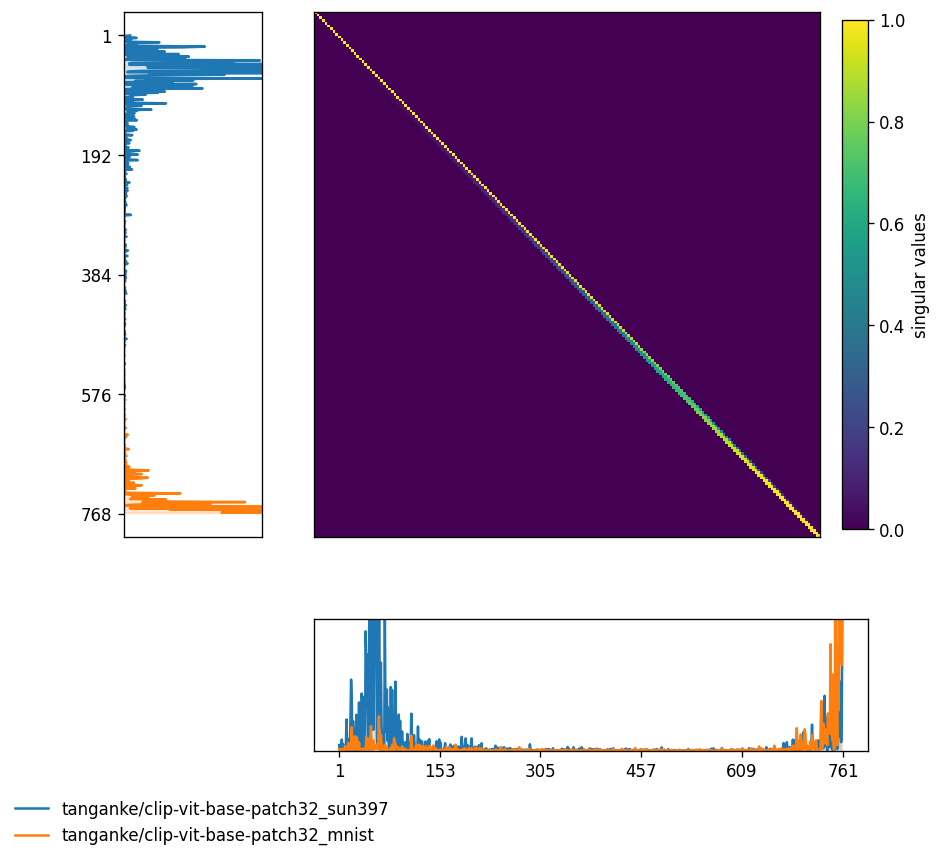

=== vision_model.encoder.layers.5.mlp.fc2 ===
=== tanganke/sun397 ===


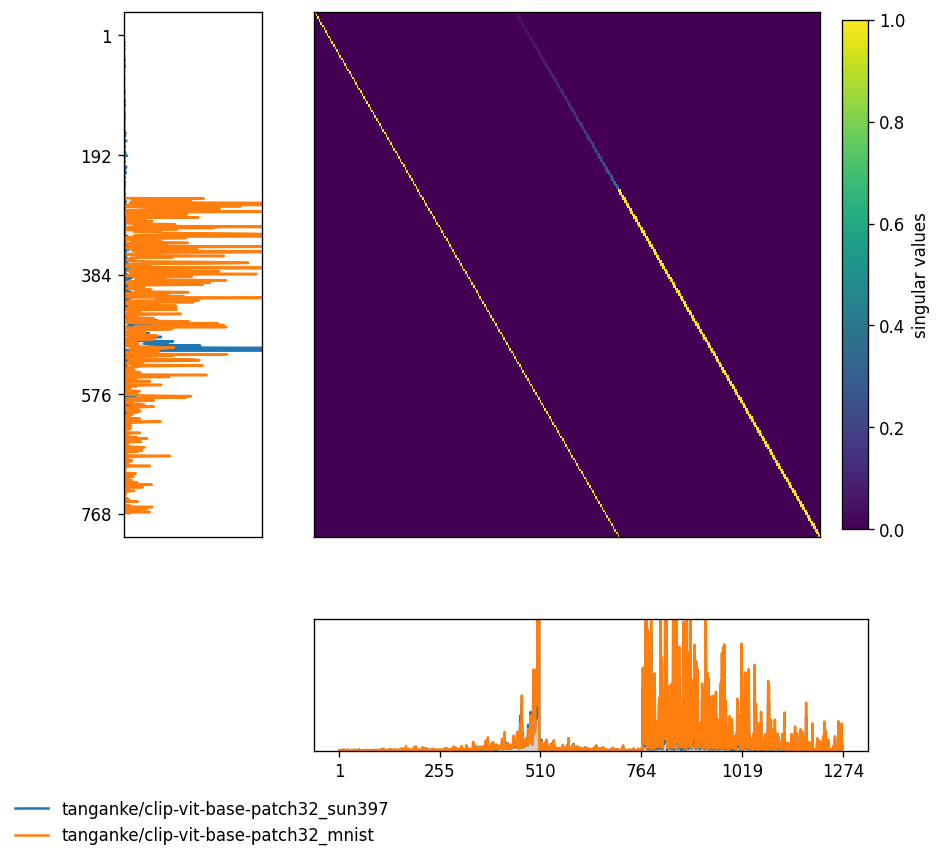

=== vision_model.encoder.layers.5.mlp.fc2 ===
=== ylecun/mnist ===


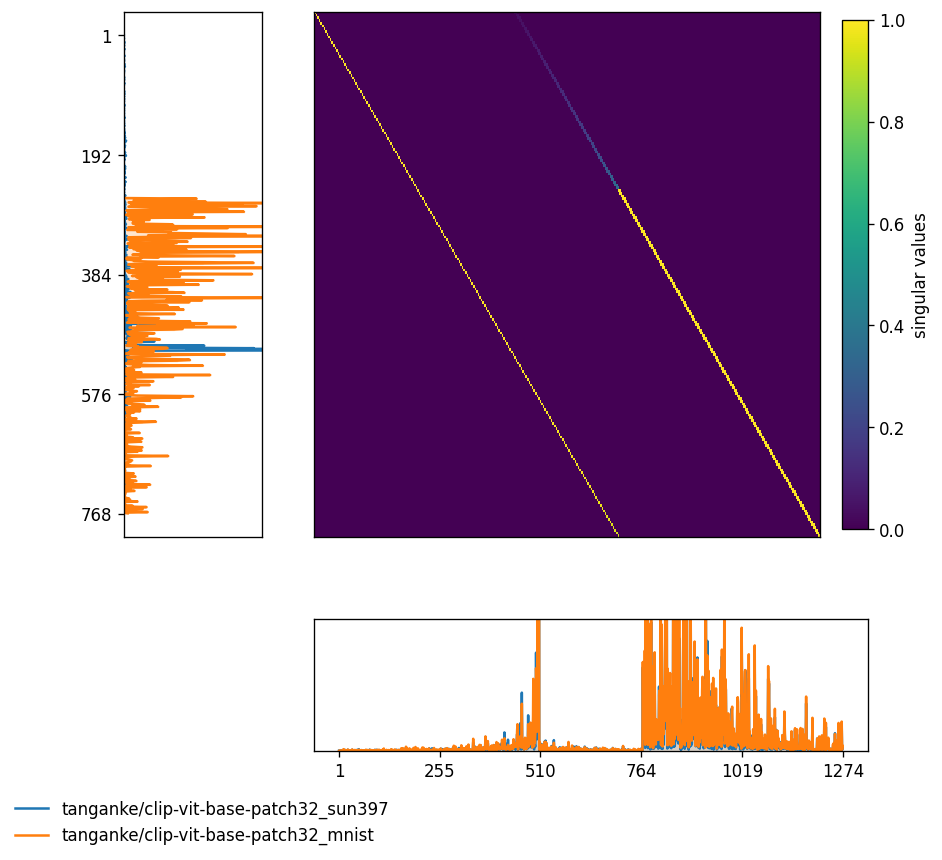

=== vision_model.encoder.layers.5.self_attn.v_proj ===
=== tanganke/sun397 ===


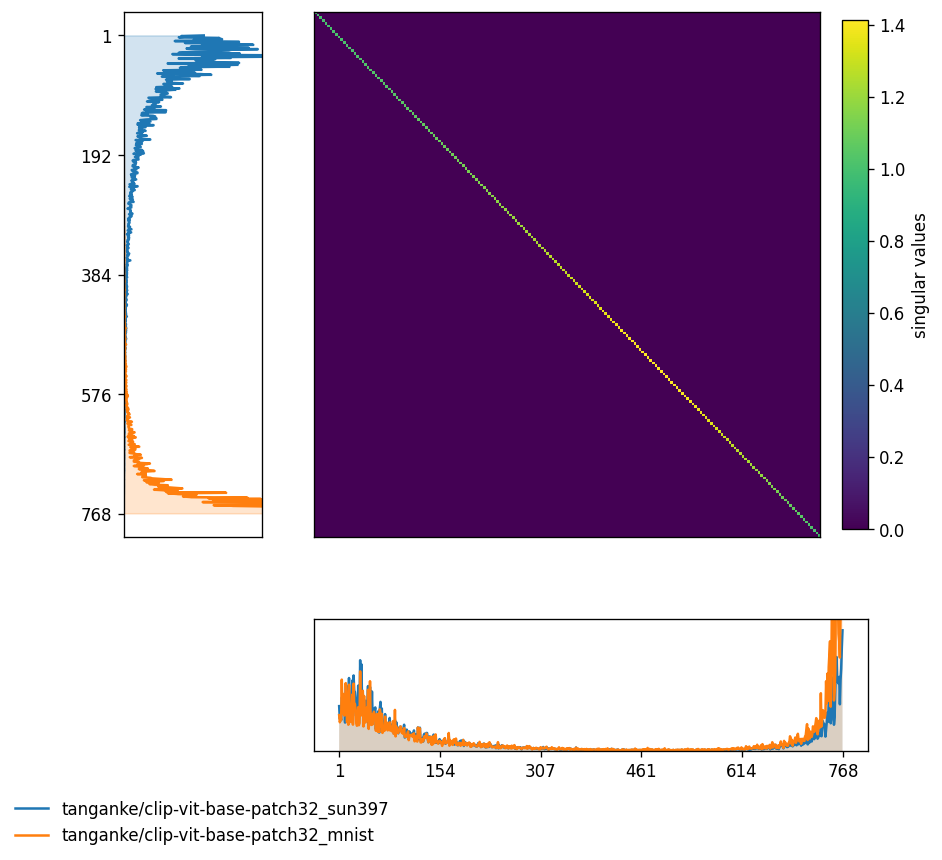

=== vision_model.encoder.layers.5.self_attn.v_proj ===
=== ylecun/mnist ===


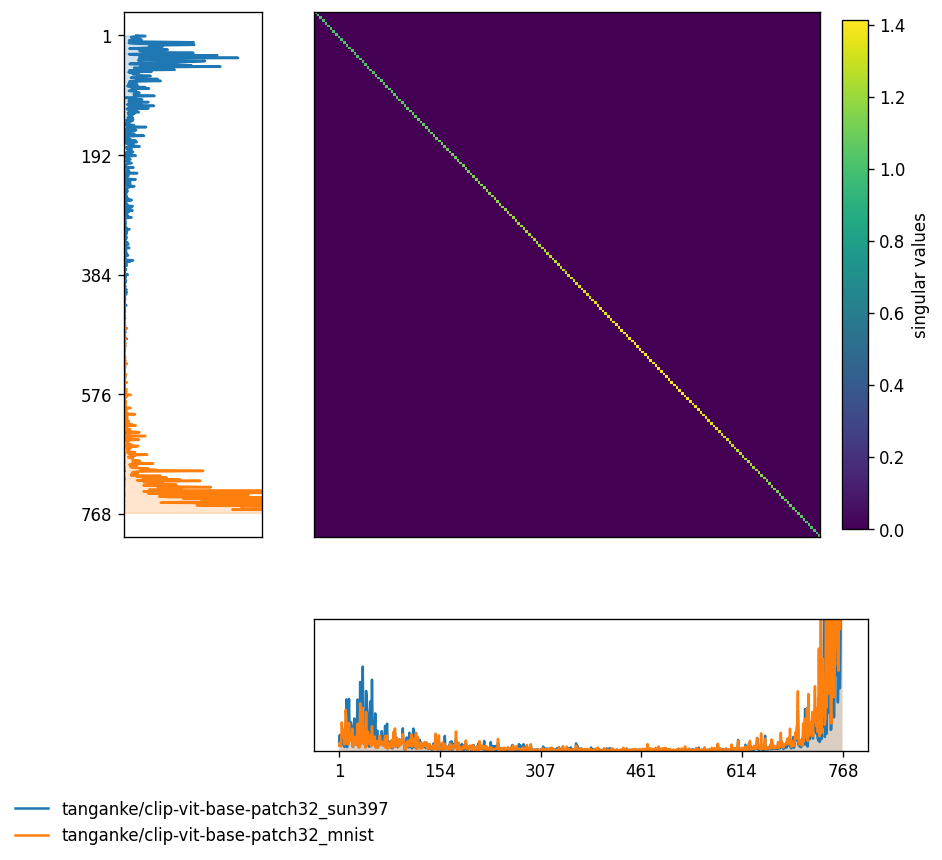

=== vision_model.encoder.layers.4.mlp.fc1 ===
=== tanganke/sun397 ===


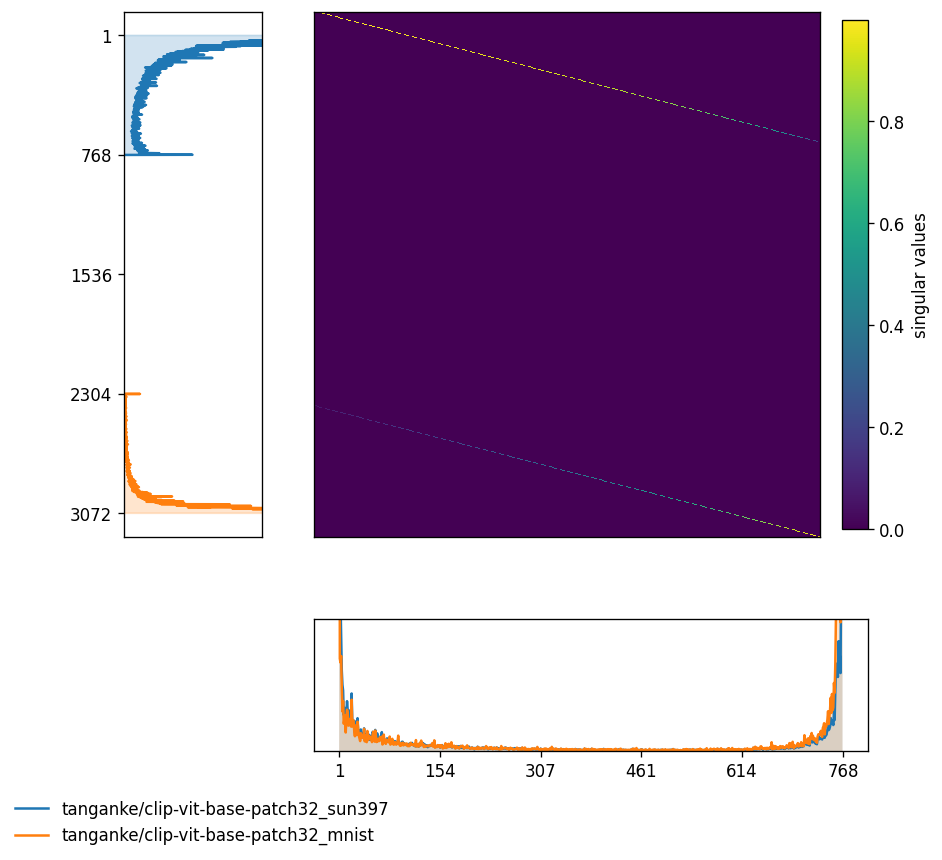

=== vision_model.encoder.layers.4.mlp.fc1 ===
=== ylecun/mnist ===


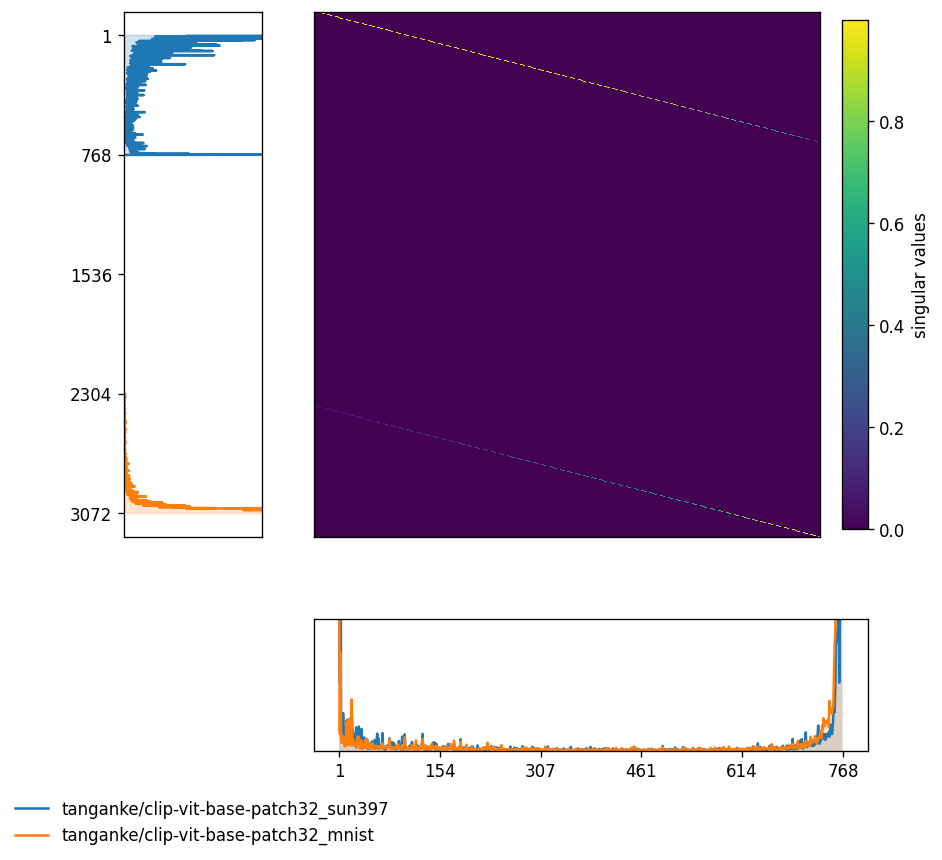

=== vision_model.encoder.layers.2.mlp.fc2 ===
=== tanganke/sun397 ===


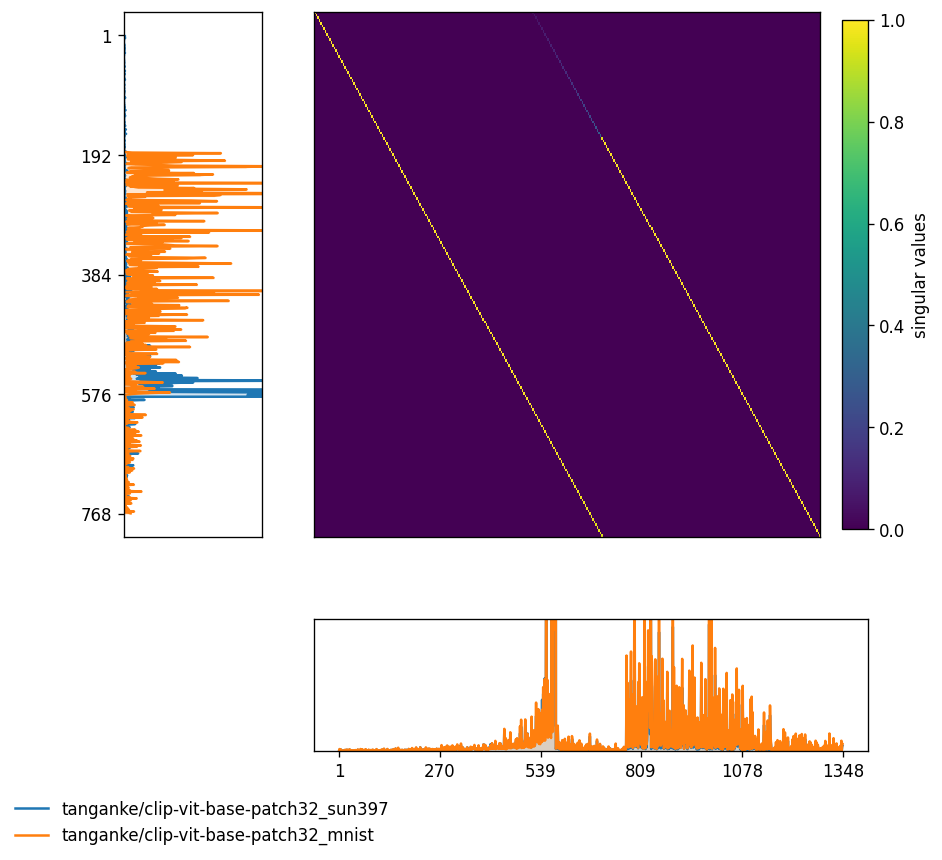

=== vision_model.encoder.layers.2.mlp.fc2 ===
=== ylecun/mnist ===


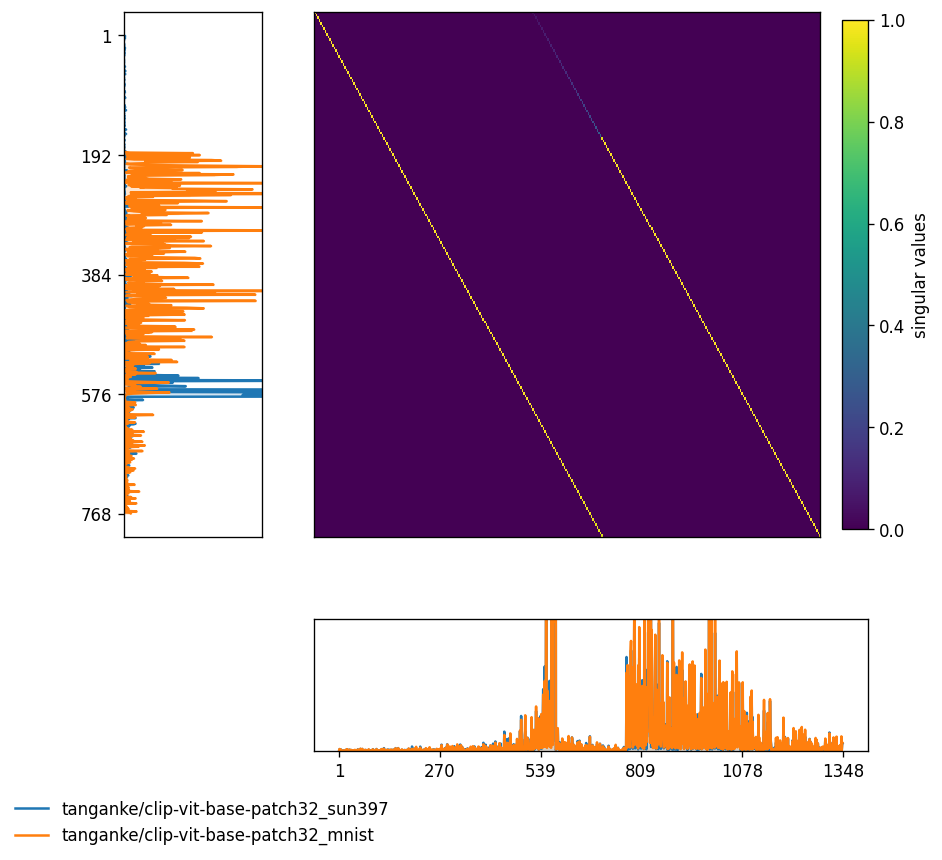

=== vision_model.encoder.layers.2.self_attn.v_proj ===
=== tanganke/sun397 ===


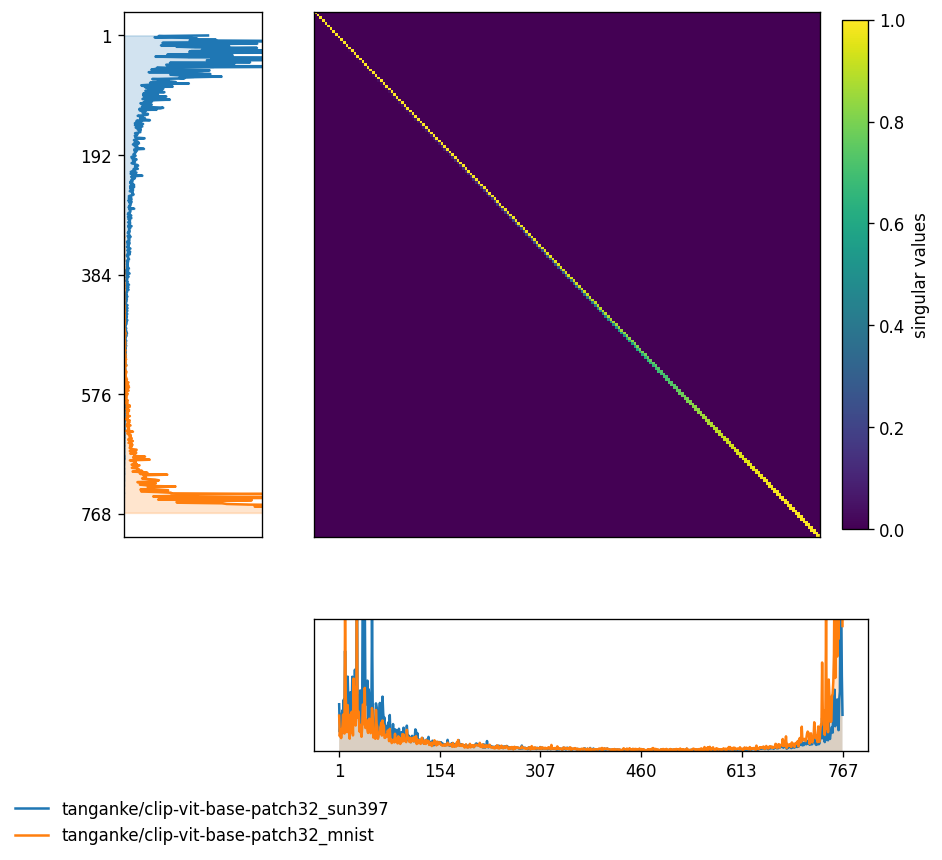

=== vision_model.encoder.layers.2.self_attn.v_proj ===
=== ylecun/mnist ===


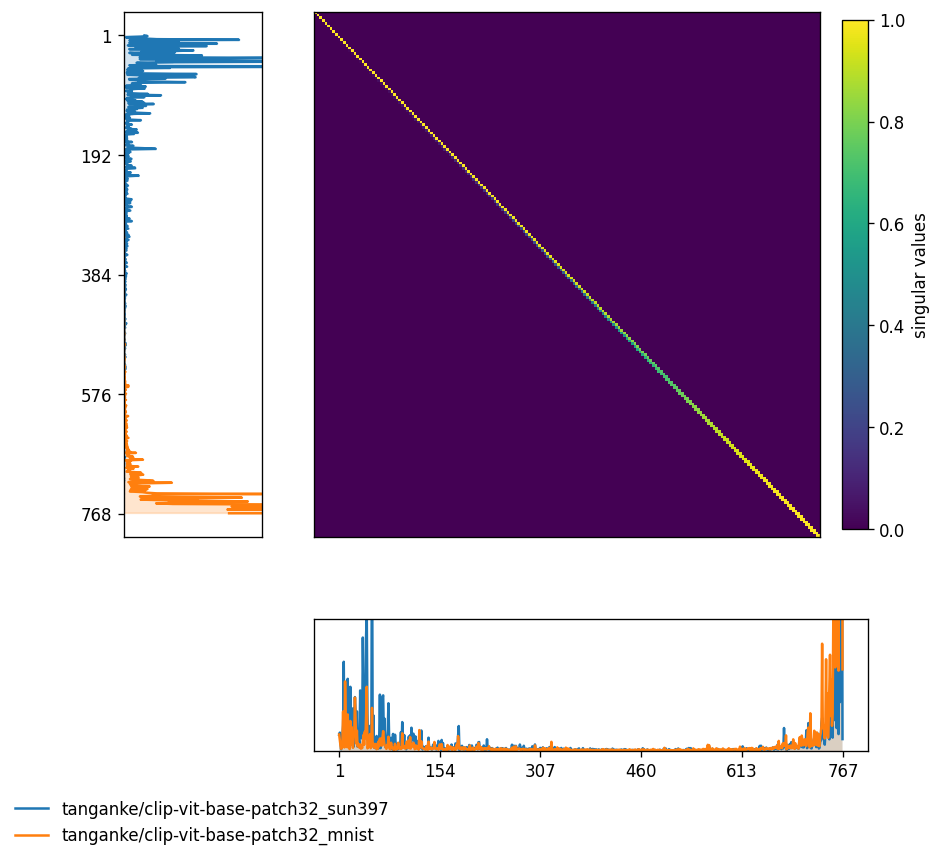

=== vision_model.encoder.layers.1.mlp.fc2 ===
=== tanganke/sun397 ===


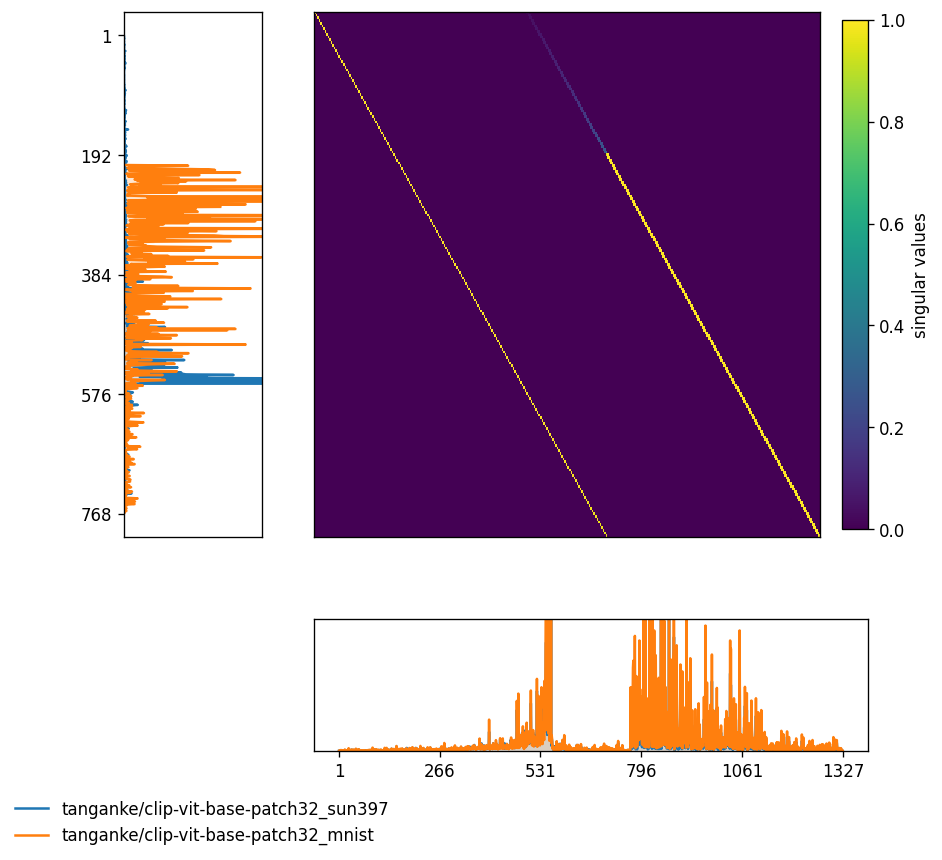

=== vision_model.encoder.layers.1.mlp.fc2 ===
=== ylecun/mnist ===


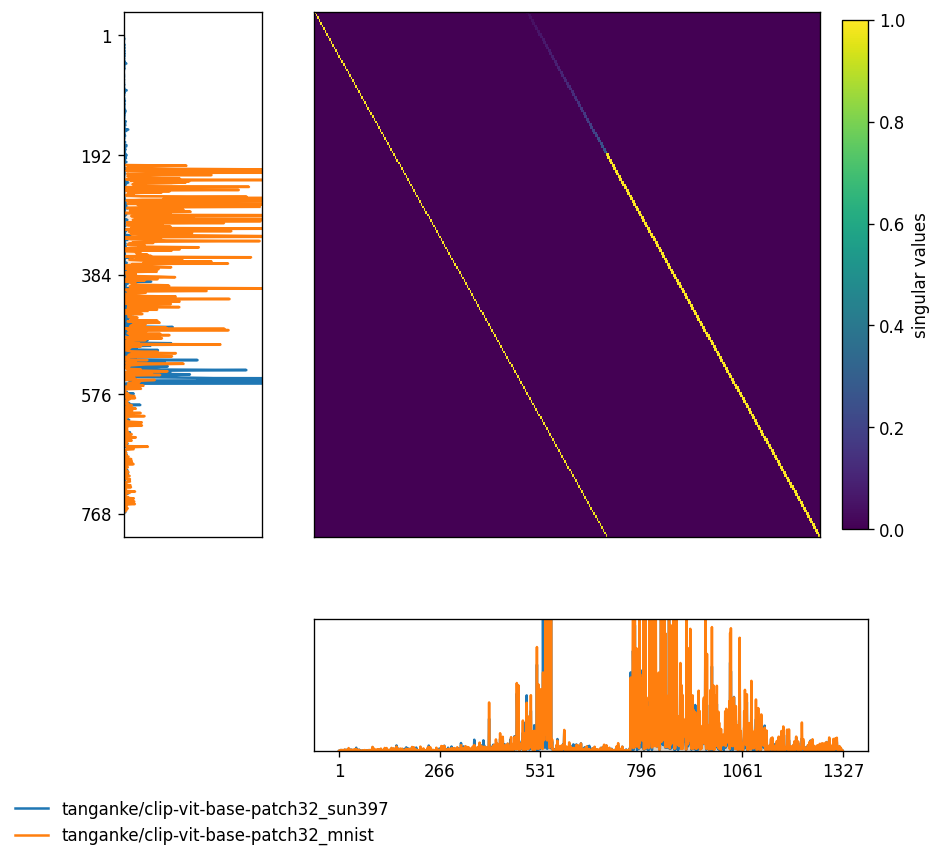

=== vision_model.encoder.layers.9.self_attn.k_proj ===
=== tanganke/sun397 ===


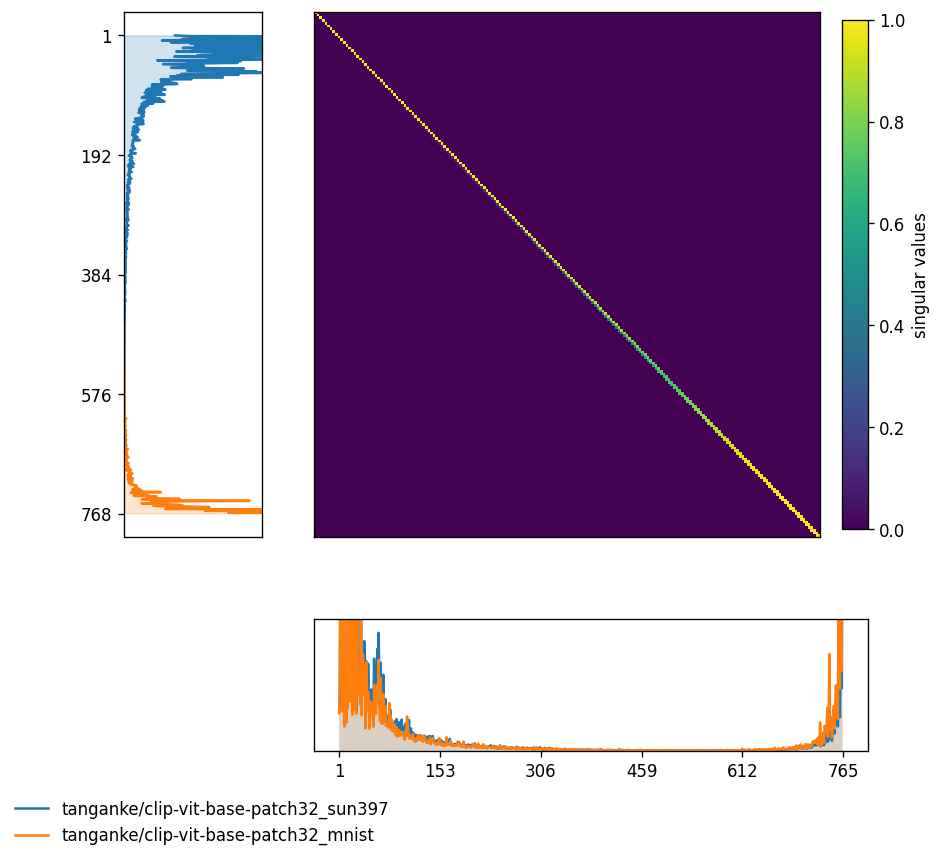

=== vision_model.encoder.layers.9.self_attn.k_proj ===
=== ylecun/mnist ===


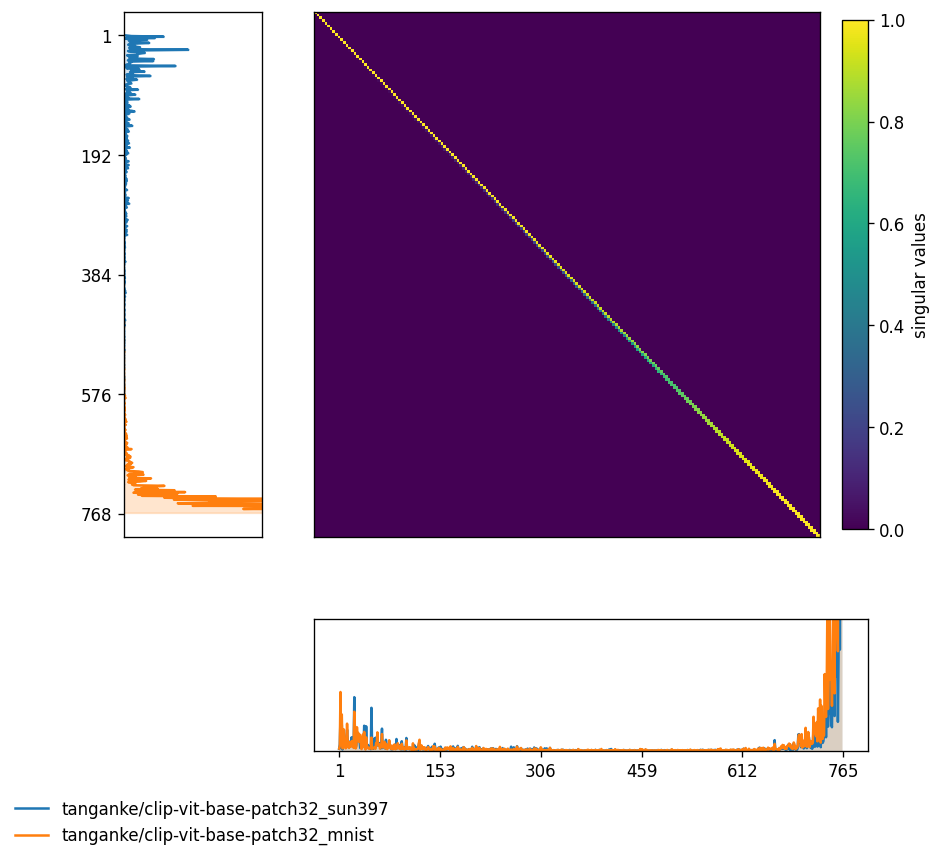

=== vision_model.encoder.layers.0.self_attn.q_proj ===
=== tanganke/sun397 ===


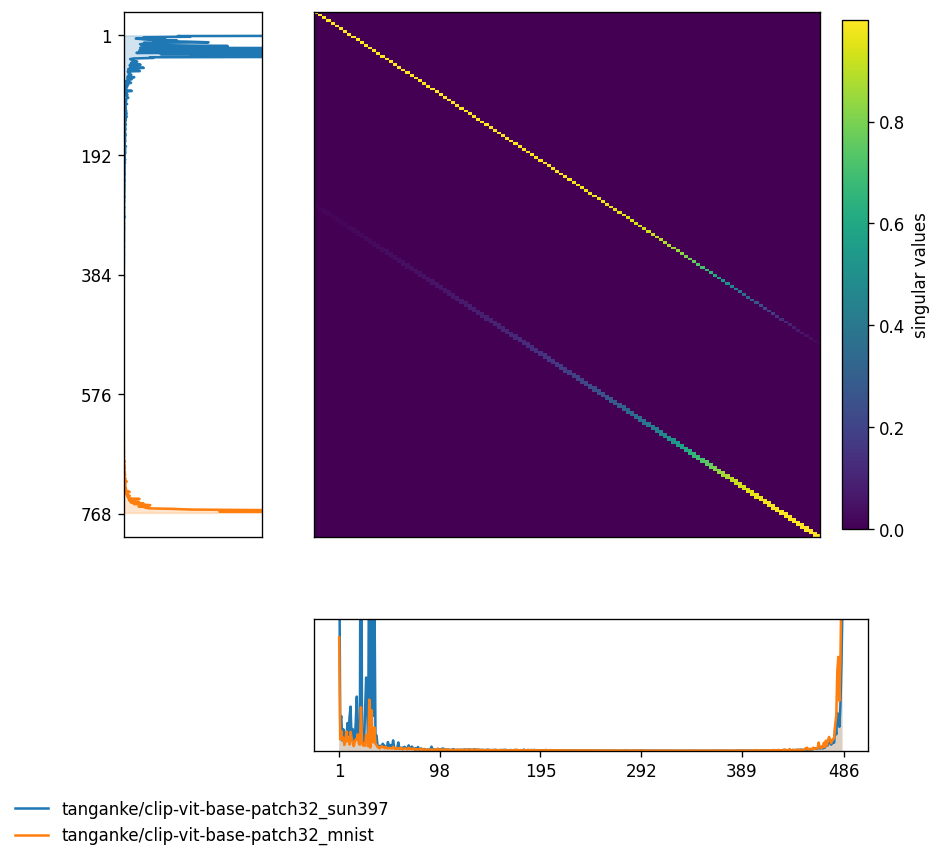

=== vision_model.encoder.layers.0.self_attn.q_proj ===
=== ylecun/mnist ===


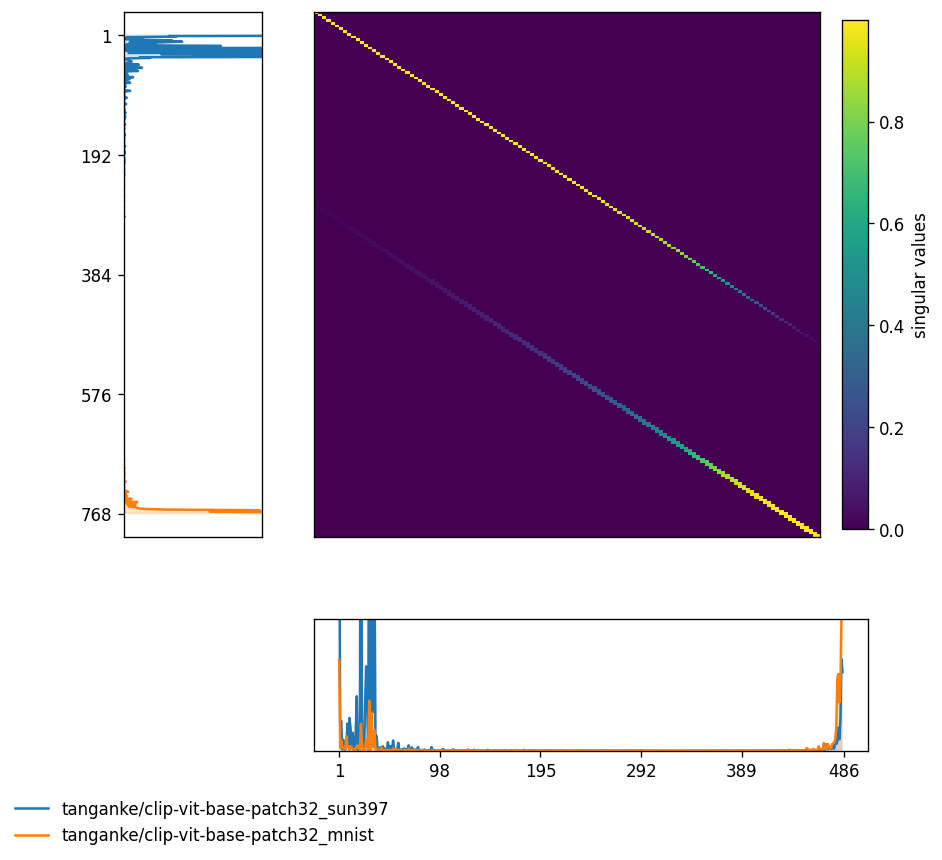

=== vision_model.encoder.layers.0.self_attn.v_proj ===
=== tanganke/sun397 ===


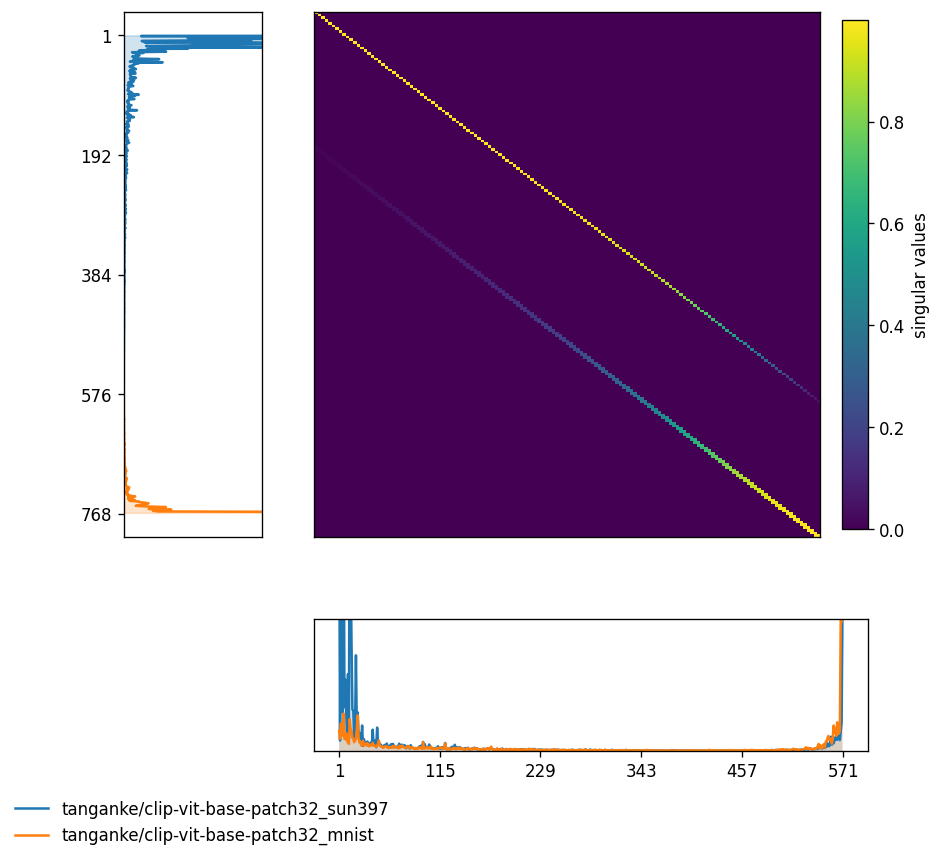

=== vision_model.encoder.layers.0.self_attn.v_proj ===
=== ylecun/mnist ===


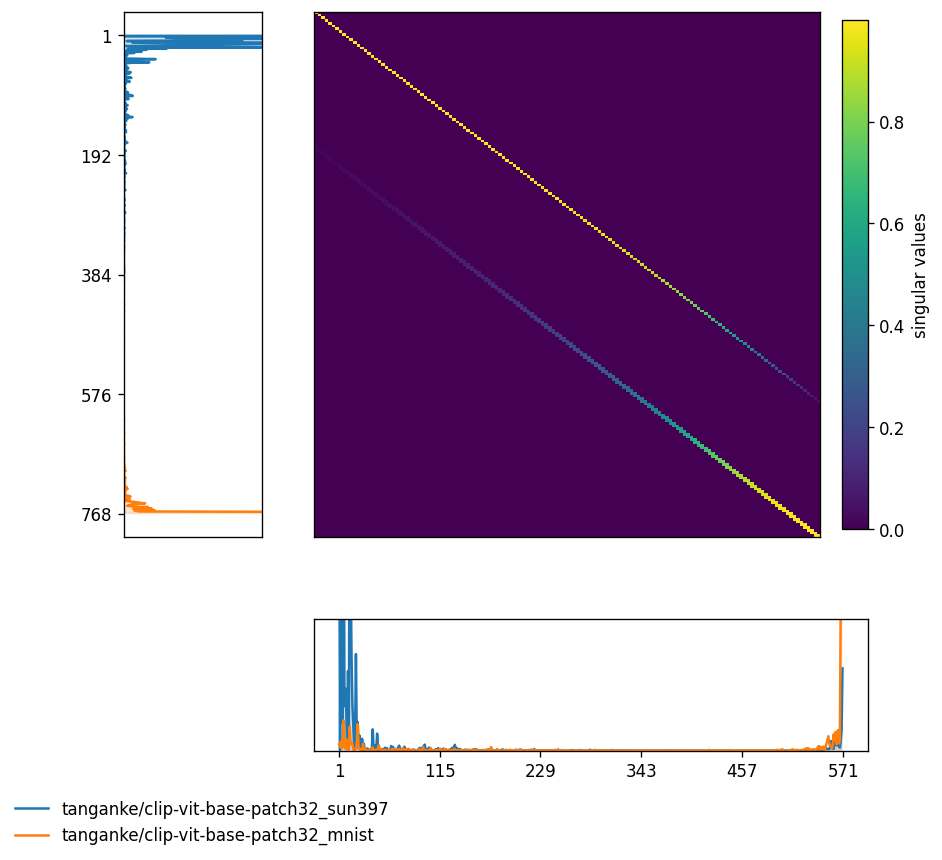

=== vision_model.encoder.layers.0.mlp.fc2 ===
=== tanganke/sun397 ===


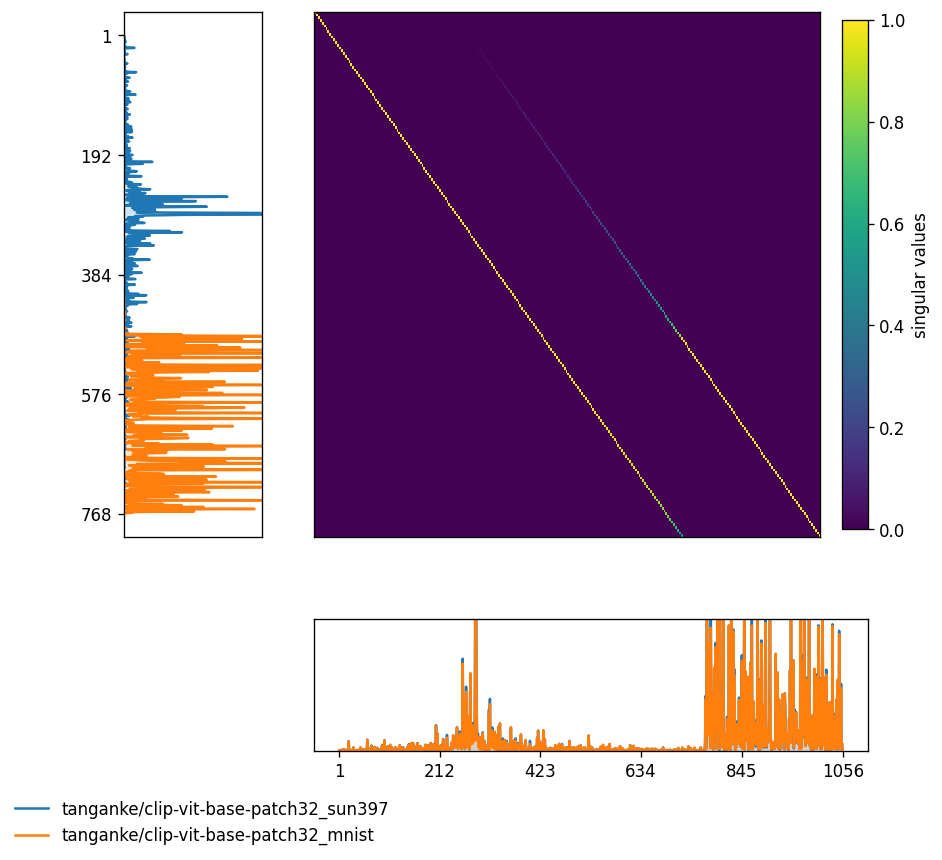

=== vision_model.encoder.layers.0.mlp.fc2 ===
=== ylecun/mnist ===


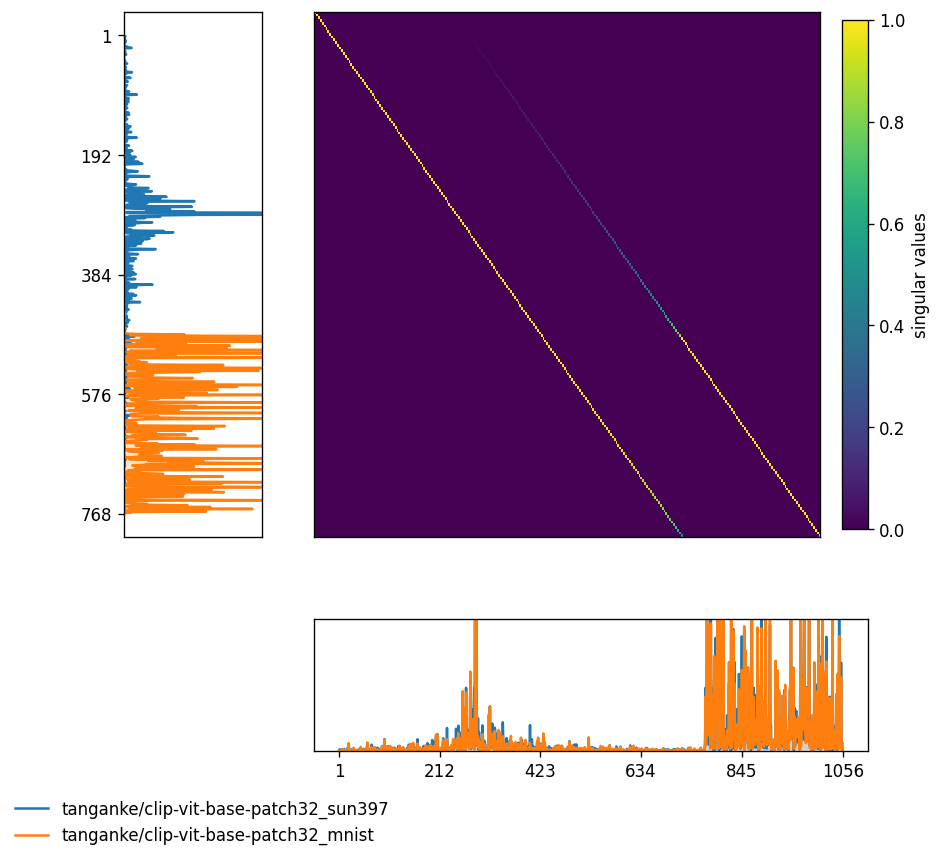

In [20]:
plot_energy_layers(energies,combos)

In [21]:
combos = list(X_dicts.keys())
print(combos)


[('tanganke/clip-vit-base-patch32_sun397', 'ylecun/mnist'), ('tanganke/clip-vit-base-patch32_sun397', 'tanganke/sun397'), ('tanganke/clip-vit-base-patch32_mnist', 'ylecun/mnist'), ('tanganke/clip-vit-base-patch32_mnist', 'tanganke/sun397')]


In [22]:
def lower_right_diag(Sigma):
    return torch.flip(torch.diag(torch.flip(Sigma,dims=(0,1))),dims=(0,))

def closest_idx(alpha, beta):
    if len(alpha) != len(beta):
        return -1
    diff = torch.abs(alpha - beta)
    return int(torch.argmin(diff).item())

In [23]:
def cutoff(m,k, Sigma1, Sigma2, gamma):
    sigma1 = Sigma1.clone()
    sigma2 = Sigma2.clone()
    alpha = torch.diag(Sigma1)
    beta = lower_right_diag(Sigma2)
    cut = -1
    if m >= 2*k:
        print("no cut")
        cut = int(m/2)
    elif m >= k:
        print("m>=k cut")
        touch = closest_idx(alpha, beta)
        cut =  int((m-k)/2)+touch
    else: #m < k
        print("m<k cut")
        cut = int(m/2)
        #alpha = torch.cat((torch.zeros(k-m,device=alpha.device),alpha),0)
        #beta = torch.cat((beta,torch.zeros(k-m,device=beta.device)),0)
        #touch = closest_idx(alpha, beta)
        cut = int(gamma*m)
        

    sigma1[cut:,:] = 0
    sigma2[:cut,:] = 0

    return sigma1, sigma2, cut

In [24]:
import seaborn as sns
svd_dict_1 = SVD_dicts[model_names[0]]
svd_dict_2 = SVD_dicts[model_names[1]]
#ds_name = ds_info["hf_name"]


for layer_name, (U1, S1, V1) in svd_dict_1.items():
    U1 = U1.to(device)        # [d_out, r1]
    V1 = V1.to(device)        # [d_in,  r1]
    S1 = S1.to(device)
    tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
    U2, S2, V2 = svd_dict_2[layer_name]
    U2 = U2.to(device)        # [d_out, r2]
    V2 = V2.to(device)        # [d_in,  r2]
    S2 = S2.to(device)
    tau2 = U2 @ torch.diag_embed(S2) @ V2.T

    U,Sigma_1,V,Sigma_2,W,R,Q,k = gsvd(tau1,tau2)

    print("===",layer_name,"===")
    print("k=",k)
    n=Q.shape[0]
    WtR = W.T@R
    if k < n:
        zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
        WtR= torch.cat([WtR, zeros_pad], dim=1)
    M = WtR@Q.T
    m = U.shape[0]
    S_1, S_2, cut = cutoff(m,k,Sigma_1, Sigma_2,0.5)
    
    tau_1_f = U@Sigma_1@M
    tau_2_f = V@Sigma_2@M
    #print(torch.norm(tau1 - tau_1_p)/torch.norm(tau1),torch.norm(tau2 - tau_2_p)/torch.norm(tau2))
    
    print("cut=",cut)
    print("errors in sigma:")
    print(torch.norm(Sigma_1-S_1)/torch.norm(Sigma_1),torch.norm(Sigma_2-S_2)/torch.norm(Sigma_2))

    #print(torch.norm(tau1 - tau_1_p)/torch.norm(tau1),torch.norm(tau2 - tau_2_p)/torch.norm(tau2))
    tau_1_p = U@S_1@M
    tau_2_p = V@S_2@M

    for ds_info in dataset_infos:
        ds = ds_info["hf_name"]

        model1 = model_names[0]
        model2 = model_names[1]

        combo1 = (model1,ds)
        combo2 = (model2,ds)

        #X1 = X_dicts[combo1][layer_name]
        #H1 = H_dicts[combo1][layer_name]
        Z1 = X_dicts[combo1][layer_name].to('cuda') @ (tau1).T.to('cuda')
        Z2 = X_dicts[combo2][layer_name].to('cuda') @ (tau2).T.to('cuda')
        
        print(ds)
        print("pre-cut drift:")
        print(model_names[0],torch.norm(Z1.to('cuda')- X_dicts[combo1][layer_name].to('cuda') @ (tau_1_f).T.to('cuda'))
              /torch.norm(Z1),"\n",
              model_names[1],torch.norm(Z2.to('cuda')- X_dicts[combo2][layer_name].to('cuda') @ (tau_2_f).T.to('cuda'))
              /torch.norm(Z2))
        print("post-cut drift:")
        print(model_names[0],torch.norm(Z1.to('cuda')- X_dicts[combo1][layer_name].to('cuda') @ (tau_1_p).T.to('cuda'))
              /torch.norm(Z1),"\n",
              model_names[1],torch.norm(Z2.to('cuda')- X_dicts[combo2][layer_name].to('cuda') @ (tau_2_p).T.to('cuda'))
              /torch.norm(Z2))
        print("---")
    
    

=== vision_model.encoder.layers.2.self_attn.q_proj ===
k= 647
m>=k cut
cut= 507
errors in sigma:
tensor(0.1154, device='cuda:0') tensor(0.2536, device='cuda:0')
ylecun/mnist
pre-cut drift:
tanganke/clip-vit-base-patch32_sun397 tensor(0.0071, device='cuda:0') 
 tanganke/clip-vit-base-patch32_mnist tensor(0.0066, device='cuda:0')
post-cut drift:
tanganke/clip-vit-base-patch32_sun397 tensor(0.0439, device='cuda:0') 
 tanganke/clip-vit-base-patch32_mnist tensor(0.0373, device='cuda:0')
---
tanganke/sun397
pre-cut drift:
tanganke/clip-vit-base-patch32_sun397 tensor(0.0074, device='cuda:0') 
 tanganke/clip-vit-base-patch32_mnist tensor(0.0093, device='cuda:0')
post-cut drift:
tanganke/clip-vit-base-patch32_sun397 tensor(0.0420, device='cuda:0') 
 tanganke/clip-vit-base-patch32_mnist tensor(0.0557, device='cuda:0')
---
=== vision_model.encoder.layers.0.self_attn.out_proj ===
k= 761
m>=k cut
cut= 558
errors in sigma:
tensor(0.2310, device='cuda:0') tensor(0.4269, device='cuda:0')
ylecun/mnist
